Problem Statement: Make sure to state the metric we're using to evaluate fit!  In our case, it's RMSE.

# Imports

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Data Import: Training Set

In [2]:
#Import data
df = pd.read_csv('../datasets/train.csv')

# Checking Missing Values

In [3]:
#Look for missing values
variables_with_missing = df.isnull().sum().index
missing_nos = df.isnull().sum().values

for i in range(len(variables_with_missing)):
    if missing_nos[i] != 0:
        print(f'{missing_nos[i]} missing values from variable {variables_with_missing[i]}')

330 missing values from variable Lot Frontage
1911 missing values from variable Alley
22 missing values from variable Mas Vnr Type
22 missing values from variable Mas Vnr Area
55 missing values from variable Bsmt Qual
55 missing values from variable Bsmt Cond
58 missing values from variable Bsmt Exposure
55 missing values from variable BsmtFin Type 1
1 missing values from variable BsmtFin SF 1
56 missing values from variable BsmtFin Type 2
1 missing values from variable BsmtFin SF 2
1 missing values from variable Bsmt Unf SF
1 missing values from variable Total Bsmt SF
2 missing values from variable Bsmt Full Bath
2 missing values from variable Bsmt Half Bath
1000 missing values from variable Fireplace Qu
113 missing values from variable Garage Type
114 missing values from variable Garage Yr Blt
114 missing values from variable Garage Finish
1 missing values from variable Garage Cars
1 missing values from variable Garage Area
114 missing values from variable Garage Qual
114 missing val

## General Approach to Missing Data
Looking at the [data description](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), we see that some variables may be recorded as "NA" or "None" to mean *not* that the data set is missing an observation, but instead that a certain feature is missing.  For example, the variable "Alley" is supposed to take on 3 values: 'Grvl', 'Pave' and 'NA'.  But we see that all the non-missing values are 'Grvl' or 'Pave' (see cell below).  So this means that most likely these values were not *missing* but were recorded as empty if they met certain criteria.

Our general approach to checking for missing values will be: for each variable, first check the data description for whether "NA" or "None" (etc.) could represent a category rather than a missing value.  If so, replace all instances of that missing value with "DNE" (Does Not Exist).  If not, we'll deal with the missing entry as though it is actually missing.

Secondly, looking at the list of missing values in the previous cell, we see that often times several variables relate to the same part of the house.  For example, there are many variables with the word `Bsmt` (basement) in them.  Many of these variables seem to be *missing exactly 55 entries, or just a few more than 55 entries*.  Looking at the data description, wherein we find that "NA" means "No Basement", it is plausible to think that all 55 of the missing values for each of the `Bsmt` variables come from the same 55 houses.  We'll verify that this is the case before replacing these variables' 55 missing values with the string `no_bsmt`.

But what do we do with the `Bsmt` variables that are missing *more than 55 entries*?  For example, `Bsmt Exposure` is missing 58 values, not 55.  If we applied the same approach to this variable as we did to the other `Bsmt` variables that were missing exactly 55 entries, we would essentially be concluding that all 58 of these missing entries correspond to homes with no basements (and not to actual missing data).  But it is not plausible that *more than 55 of the houses in the data set had no basement*, since several of the `Bsmt` variables were missing *only 55 entries, and the same 55 in each of these variables*.  It therefore seems more likely that 55 of the 58 missing values in `Bsmt Exposure` are those same 55 homes that were elsewhere recorded to have no basement, while the other 3 missing values are actually missing.  So assuming that exactly 55 of the missing values for `Bsmt Exposure` match up to the same 55 houses from before, we'll replace only *these* missing values with the string `no_bsmt`, while leaving the other 3 values missing for now.

Similar remarks apply to the many variables relating to the garage that are missing around 114 entries.

In this notebook, we'll investigate the data and determine which data points are genuinely missing, as opposed to being entered as missing even though their values were known.  We will drop these values that are genuinely missing, as well as the "outliers" mentioned in the data description.  After this is done, we will have completed our "data preparing" phase.

In [the next notebook](./2_data_cleaning.ipynb), we will "clean" the data: we will fill in all missing values according to the process described above and make any other changes necessary for our analysis.

## Basements
We can see that 3 of the `Bsmt` variables are missing 55 values.  Let's check that these are all the same 55 rows in each case:

In [4]:
condition = df['Bsmt Qual'].isnull() | df['Bsmt Cond'].isnull() | df['BsmtFin Type 1'].isnull()
#Look at those rows with ANY of these three variables missing

len(df[condition])
#This should equal 55 if all the homes missing one of these variables are missing the other two as well

55

So these 3 variables' 55 missing entries all correspond to the same 55 homes.  Let's check if these same 55 are missing from `Bsmt Exposure` and `BsmtFin Type 2`:

In [5]:
#Bsmt Exposure
condition1 = df['Bsmt Qual'].isnull() & df['Bsmt Exposure'].isnull() & df['BsmtFin Type 2'].isnull()
#Look at those rows with ALL THREE of these variables missing

len(df[condition1])
#This should equal 55 if all 55 of those homes that are missing Bsmt Qual also have  missing values
#in these other two variables

55

So the variables `Bsmt Exposure` and `BsmtFin Type 2` are missing the same 55 homes as those missing from `Bsmt Qual`, plus 3 more for `Bsmt Exposure` and 1 more for `BsmtFin Type 2`.  We'll assume that those 3 more and 1 more are *legitimately missing values* and remove these data points from our data set.  So let's record these "legitimately missing" values' indices so that we can remove them later:

In [6]:
#Which observations are missing 'Bsmt Exposure' but are NOT among the 55 homes accounted for above?
drops = df[df['Bsmt Exposure'].isnull() & ~df['Bsmt Qual'].isnull()].index

#Store these in a list for later
drop_indices = list(drops)

#Examine these data points
df.iloc[ drops ]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1456,1797,528458090,60,FV,81.0,10411,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,2007,New,212109
1547,67,528445060,20,RL,73.0,8987,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,5,2010,WD,221500
1997,2780,907194130,60,RL,65.0,14006,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,2,2006,WD,192500


In [7]:
#Which observation is missing 'BsmtFin Type 2' but is NOT among the 55 homes accounted for above?
drop = df[df['BsmtFin Type 2'].isnull() & ~df['Bsmt Qual'].isnull()].index

#Add its index to our list to drop later
drop_indices.extend(list(drop))

#Examine this value
df.iloc[ drop ]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1147,445,528142130,20,RL,85.0,10655,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,10,2009,WD,284000


In [8]:
#Check that we've recorded the right indices to drop later
drop_indices

[1456, 1547, 1997, 1147]

In summary: none of the 3 observations with missing `Bsmt Exposure` values are the same as the one missing its `BsmtFin Type 2` value.

In any case, we'll want to drop these values later, so we'll keep track of their indices with `drop_indices`.

Now let's move on to the other `Bsmt` variables that were missing some observations:

In [9]:
#Now examine other 'Bmst' varialbes that had missing values (each had 1)
bsmts2 = ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']
for col in bsmts2:
    print(f"Number of rows with missing {col} value: {len(df[df[col].isnull()])}")

Number of rows with missing BsmtFin SF 1 value: 1
Number of rows with missing BsmtFin SF 2 value: 1
Number of rows with missing Bsmt Unf SF value: 1
Number of rows with missing Total Bsmt SF value: 1


In [10]:
#Are these missing values all the same one?
df[ df['BsmtFin SF 1'].isnull() & df['BsmtFin SF 2'].isnull() & df['Bsmt Unf SF'].isnull() & df['Total Bsmt SF'].isnull() ]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1327,1342,903230120,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,...,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,79000


In [11]:
#They are! How about these other cloumn names that were missing exactly 2 values?
bsmts3 = ['Bsmt Full Bath', 'Bsmt Half Bath']
for col in bsmts3:
    print(f"Number of rows with missing {col} value: {len(df[df[col].isnull()])}")
    
df[ df['Bsmt Full Bath'].isnull() & df['Bsmt Half Bath'].isnull() ]

Number of rows with missing Bsmt Full Bath value: 2
Number of rows with missing Bsmt Half Bath value: 2


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
616,1498,908154080,20,RL,123.0,47007,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,7,2008,WD,284700
1327,1342,903230120,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,...,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,79000


In summary: Observation number 1327 is missing all 6 of the values listed in `bsmts2` and `bsmts3`, while observation number 616 is only missing the two values in `bsmts3`.

Meanwhile, 4 other observations were legitimately missing their `Bsmt Exposure` or `BsmtFin Type 2` values; we already recorded their indices in our `drop_indices` list.

I think we can safely drop these 6 observations, as our data set has over 2000 observations.

In [12]:
#Add these last two to our list of indices to drop
drop_indices.extend( list( df[ df['Bsmt Full Bath'].isnull() ].index) )
drop_indices

[1456, 1547, 1997, 1147, 616, 1327]

In [13]:
len(df)

2051

In [14]:
#Drop these 6 observations
df.drop(index=drop_indices, inplace=True)
len(df)

2045

In [15]:
#Check the null counts to make sure nothing is still missing
bsmts = ['Bsmt Qual', 'Bsmt Cond', 'BsmtFin Type 1', 'Bsmt Exposure', 'BsmtFin Type 2']

for col in bsmts + bsmts2 + bsmts3:
    print(f"Number of rows with missing {col} value: {len(df[df[col].isnull()])}")

Number of rows with missing Bsmt Qual value: 53
Number of rows with missing Bsmt Cond value: 53
Number of rows with missing BsmtFin Type 1 value: 53
Number of rows with missing Bsmt Exposure value: 53
Number of rows with missing BsmtFin Type 2 value: 53
Number of rows with missing BsmtFin SF 1 value: 0
Number of rows with missing BsmtFin SF 2 value: 0
Number of rows with missing Bsmt Unf SF value: 0
Number of rows with missing Total Bsmt SF value: 0
Number of rows with missing Bsmt Full Bath value: 0
Number of rows with missing Bsmt Half Bath value: 0


In [16]:
#Re-index after dropping (failing to do so may cause errors)
df.reset_index(inplace=True,drop=True)
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


## Garages

In [17]:
garages = ['Garage Qual', 'Garage Cond', 'Garage Finish', 'Garage Yr Blt', 'Garage Type']

In [18]:
df[garages + ['Garage Cars', 'Garage Area']].isnull().sum()

Garage Qual      114
Garage Cond      114
Garage Finish    114
Garage Yr Blt    114
Garage Type      113
Garage Cars        1
Garage Area        1
dtype: int64

In [19]:
#Check if all 114 are the same homes. If so, this should yield 114
len(df[ df['Garage Qual'].isnull() & df['Garage Cond'].isnull() & df['Garage Finish'].isnull() & df['Garage Yr Blt'].isnull() ])

114

In [20]:
#Check if those 113 are a subset of the 114. If so, this should yield 113
len(df[ df['Garage Qual'].isnull() & df['Garage Type'].isnull() ])

113

In [21]:
#Which data point is the one that's missing all the Garage values EXCEPT `Garage Type`?
df[ df['Garage Qual'].isnull() & ~df['Garage Type'].isnull() ]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1707,2237,910201180,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,...,0,0,NaN,MnPrv,NaN,0,3,2007,WD,150909


In [22]:
#Is this the same one observation that's missing both `Garage Cars` and `Garage Area`?
df[df['Garage Cars'].isnull() & df['Garage Area'].isnull()]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1707,2237,910201180,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,...,0,0,NaN,MnPrv,NaN,0,3,2007,WD,150909


In [23]:
#It is! So we'll just drop that one observation, then later fill the other 113 with "DNE"

#First, get the index of the one observation to drop:
drop_index = df[df['Garage Cars'].isnull() & df['Garage Area'].isnull()].index
drop_index

Int64Index([1707], dtype='int64')

In [24]:
#Drop this observation
df.drop(index=drop_index, inplace=True)

#Check that it was dropped
df[df['Garage Cars'].isnull() & df['Garage Area'].isnull()]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice


In [25]:
#Reset the index after dropping, so as not to create issues
df.reset_index(inplace=True,drop=True)
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [26]:
#Check that everything adds up
for col in garages+['Garage Cars', 'Garage Area']:
    print(f"Number of rows with missing {col} value: {len(df[df[col].isnull()])}")

Number of rows with missing Garage Qual value: 113
Number of rows with missing Garage Cond value: 113
Number of rows with missing Garage Finish value: 113
Number of rows with missing Garage Yr Blt value: 113
Number of rows with missing Garage Type value: 113
Number of rows with missing Garage Cars value: 0
Number of rows with missing Garage Area value: 0


## Masonry Veneer

In [27]:
df['Mas Vnr Type'].value_counts()

None       1214
BrkFace     627
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

In [28]:
masonry = ['Mas Vnr Type', 'Mas Vnr Area']
for col in masonry:
    print(f"Number of rows with missing {col} value: {len(df[df[col].isnull()])}")

Number of rows with missing Mas Vnr Type value: 22
Number of rows with missing Mas Vnr Area value: 22


In [29]:
#Are these all the same 22 data points?
len(df[ df['Mas Vnr Type'].isnull() & df['Mas Vnr Area'].isnull() ])

22

So these 22 observations are missing both `Mas Vnr Type` and `Mas Vnr Area`.  However, an additional 1214 observations seem to have "None" as their masonry veneer type.  Let's check that these 1214 observations all have a `Mas Vnr Area` of 0:

In [30]:
#This cell should output 1214 if so
len(df[ (df['Mas Vnr Type']=='None') & (df['Mas Vnr Area']==0) ])

1209

So apparently 5 observations *have some masonry veneer area but have no masonry veneer type*.  What are these?

In [31]:
df[ (df['Mas Vnr Type']=='None') & (df['Mas Vnr Area']!=0) ][['Mas Vnr Area', 'Mas Vnr Type']]

,Mas Vnr Area,Mas Vnr Type
764,1.0,None
809,288.0,None
1146,1.0,None
1679,1.0,None
1826,344.0,None


It seems to me that the three observations with a masonry veneer area of only *one square foot* may as well be considered to have no masonry veneer at all (especially since the `Mas Vnr Type` is missing for them), meaning the "None"s in their `Mas Vnr Type` column probably truly indicate a lack of masonry veneer.  The other two of these observations likely *do* have masonry veneer; otherwise these numbers should not have appeared in their `Mas Vnr Area`.

I think the safest move is to drop these two odd data points with a large `Mas Vnr Area` and no `Mas Vnr Type`, then to set all the 'None' values to be `np.nan` so that they will be properly filled in the next notebook.

In [32]:
#Find the indices of the two observations to drop
drop_indices = df[ (df['Mas Vnr Type']=='None') & (df['Mas Vnr Area']>100) ].index
drop_indices

Int64Index([809, 1826], dtype='int64')

In [33]:
#Drop these observations
df.drop(index=drop_indices, inplace=True)

#Check that they were dropped
df[ (df['Mas Vnr Type']=='None') & (df['Mas Vnr Area']>100) ]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice


In [34]:
#Reset the index after dropping, so as not to create issues
df.reset_index(inplace=True,drop=True)
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [35]:
#Change the 'None's to np.nan

#Find the indices of these 1212 remaining observations with Mas Vnr Type == 'None'
change_indices = df[df['Mas Vnr Type']=='None'].index
len(change_indices)

1212

In [36]:
#Change these to np.nan
df.iloc[change_indices, df.columns.get_loc('Mas Vnr Type')] = np.nan

In [37]:
#Check the value counts to make sure it worked
df['Mas Vnr Type'].value_counts()

BrkFace    627
Stone      168
BrkCmn      13
Name: Mas Vnr Type, dtype: int64

In [38]:
#We should now have 22 + 1212 = 1234 missing observations
df[['Mas Vnr Type']].isnull().sum()

Mas Vnr Type    1234
dtype: int64

## Electrical (not needed for training data, but useful for test data below)

In [39]:
df['Electrical'].value_counts()

SBrkr    1860
FuseA     139
FuseF      35
FuseP       7
Mix         1
Name: Electrical, dtype: int64

## We've finished dropping "legitimately missing values."

All of the categories above (basement, garage, masonry veneer) contained similar numbers of multiple missing variables.  As we can see, all the remaining missing variables do not share anything in common:

In [40]:
#Look for missing values, again
variables_with_missing = df.isnull().sum().index
missing_nos = df.isnull().sum().values

for i in range(len(variables_with_missing)):
    if missing_nos[i] != 0:
        print(f'{missing_nos[i]} missing values from variable {variables_with_missing[i]}')

329 missing values from variable Lot Frontage
1902 missing values from variable Alley
1234 missing values from variable Mas Vnr Type
22 missing values from variable Mas Vnr Area
53 missing values from variable Bsmt Qual
53 missing values from variable Bsmt Cond
53 missing values from variable Bsmt Exposure
53 missing values from variable BsmtFin Type 1
53 missing values from variable BsmtFin Type 2
997 missing values from variable Fireplace Qu
113 missing values from variable Garage Type
113 missing values from variable Garage Yr Blt
113 missing values from variable Garage Finish
113 missing values from variable Garage Qual
113 missing values from variable Garage Cond
2033 missing values from variable Pool QC
1644 missing values from variable Fence
1977 missing values from variable Misc Feature


In each of the remaining categories, we'll use a function (in the next notebook, "data_cleaning") to fill these values with "DNE" (Does Not Exist) or with 0 as appropriate.

The only thing that sticks out from this list is the fact that there are only 22 missing values from `Mas Vnr Area` but there are 1234 missing values from `Mas Vnr Type`.  As we saw, this is because those observations that are missing a `Mas Vnr Type` but have a `Mas Vnr Area` all have a `Mas Vnr Area` of 0, which does indeed correspond to a "missing" value of `Mas Vnr Type`.

So all is accounted for!

For now, all that's left is to remove the extreme outliers mentioned in the data description.  So let's find them:

## Looking for Outliers

Text(0, 0.5, 'Sale Price ($)')

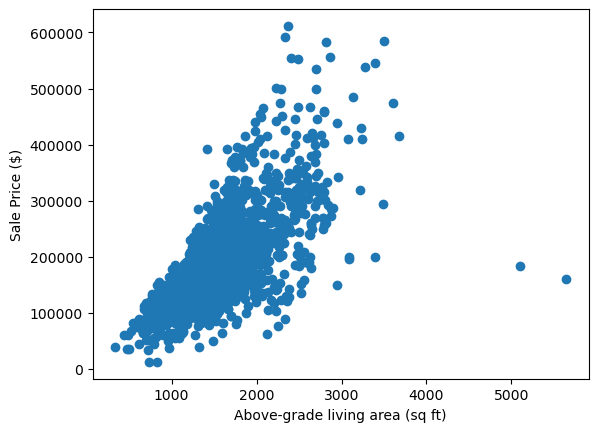

In [41]:
plt.scatter(df['Gr Liv Area'], df['SalePrice']);
plt.xlabel('Above-grade living area (sq ft)');
plt.ylabel('Sale Price ($)')

As we can see, there are two very unusual observations on the bottom-right: homes with more than 5,000 square feet of above-grade living area that "sold" for middling prices.  As the data description says, these likely represent "Partial Sales" rather than actual sales.  So we should remove these observations from our data set before doing any predictive modeling:

In [42]:
super_large = df['Gr Liv Area'] > 5000
df[super_large]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
958,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,0,480,Gd,NaN,NaN,0,1,2008,New,160000
1877,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,0,NaN,NaN,Elev,17000,10,2007,New,183850


In [43]:
#Get their indices
drop_indices = df[df['Gr Liv Area'] > 5000].index
drop_indices

Int64Index([958, 1877], dtype='int64')

In [44]:
len(df)

2042

In [45]:
#Drop these 2 outliers
df.drop(index=drop_indices, inplace=True)

#Check that exactly 2 were dropped
len(df)

2040

## Data Export: Training Set

In [46]:
df.to_csv('../datasets/train_prepared.csv', index=False)

# Test Data Set

Our approach to "preparing" this data set will be the same as what we did for the training data set.

## Data Import: Test Set

In [47]:
df=pd.read_csv('../datasets/test.csv')

In [48]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


# Checking Missing Values

In [49]:
#Look for missing values
variables_with_missing = df.isnull().sum().index
missing_nos = df.isnull().sum().values

for i in range(len(variables_with_missing)):
    if missing_nos[i] != 0:
        print(f'{missing_nos[i]} missing values from variable {variables_with_missing[i]}')

160 missing values from variable Lot Frontage
820 missing values from variable Alley
1 missing values from variable Mas Vnr Type
1 missing values from variable Mas Vnr Area
25 missing values from variable Bsmt Qual
25 missing values from variable Bsmt Cond
25 missing values from variable Bsmt Exposure
25 missing values from variable BsmtFin Type 1
25 missing values from variable BsmtFin Type 2
1 missing values from variable Electrical
422 missing values from variable Fireplace Qu
44 missing values from variable Garage Type
45 missing values from variable Garage Yr Blt
45 missing values from variable Garage Finish
45 missing values from variable Garage Qual
45 missing values from variable Garage Cond
874 missing values from variable Pool QC
706 missing values from variable Fence
837 missing values from variable Misc Feature


As we can see, things look similar to how they looked in the training data set.  We'll just double-check that all the basement-related variables that are missing come from the same 25 observations, that all the masonry-related missing values come from the same observations, and that all the 45 missing garage-related values come from the same 45 observations.

Note that the only apparent inconsistency here is that there are only *44* missing values from one of the garage-related variables, while the others are missing 45.  This warrants some investigation.

## Garages

In [50]:
#Check that all 45 missing values (except from `Garage Type`) are from the same 45 observations
#If so, this cell should ouput 45
len(df[ df['Garage Yr Blt'].isnull() & df['Garage Finish'].isnull() & df['Garage Qual'].isnull() & df['Garage Cond'].isnull() ])

45

In [51]:
#Are the 44 observations missing a `Garage Type` a subset of the 45 above?
#If so, this cell should output 44
len(df[ df['Garage Yr Blt'].isnull() & df['Garage Type'].isnull() ])

44

In [52]:
#What's going on with the 1 oobservation that's not missing a`Garage Type`
#but is missing the other 4 values?
df[ df['Garage Qual'].isnull() & ~df['Garage Type'].isnull()][['Garage Qual', 'Garage Finish', 'Garage Cond', 'Garage Yr Blt', 'Garage Type']]

,Garage Qual,Garage Finish,Garage Cond,Garage Yr Blt,Garage Type
764,NaN,NaN,NaN,NaN,Detchd


This one home has 4 variables that seem to indicate that it has no garage at all, but one variable (`Garage Type`) that says it has a "detached garage."

I think it's most likely that the filled-in `Garage Type` is an error and that in reality this home simply lacks a garage.  For this reason, I will replace this value with `np.nan` to reflect the fact that the home does not have a garage.  (In the [next notebook](./2_data_cleaning.ipynb), we will fill these missing values to reflect the fact that all this homes with missing garage-related values simply do not have garages.)

In [53]:
#First, get the index of the one observation to change:
change_index = df[df['Garage Qual'].isnull() & ~df['Garage Type'].isnull()].index
change_index


Int64Index([764], dtype='int64')

In [54]:
#Change this observation to reflect that it doesn't have a garage
df.iloc[change_index, df.columns.get_loc('Garage Type')] = np.nan

#Check that it was changed to NaN
df.iloc[change_index][['Garage Qual', 'Garage Finish', 'Garage Cond', 'Garage Yr Blt', 'Garage Type']]

,Garage Qual,Garage Finish,Garage Cond,Garage Yr Blt,Garage Type
764,NaN,NaN,NaN,NaN,NaN


In [55]:
#Check missing values again
variables_with_missing = df.isnull().sum().index
missing_nos = df.isnull().sum().values

for i in range(len(variables_with_missing)):
    if missing_nos[i] != 0:
        print(f'{missing_nos[i]} missing values from variable {variables_with_missing[i]}')

160 missing values from variable Lot Frontage
820 missing values from variable Alley
1 missing values from variable Mas Vnr Type
1 missing values from variable Mas Vnr Area
25 missing values from variable Bsmt Qual
25 missing values from variable Bsmt Cond
25 missing values from variable Bsmt Exposure
25 missing values from variable BsmtFin Type 1
25 missing values from variable BsmtFin Type 2
1 missing values from variable Electrical
422 missing values from variable Fireplace Qu
45 missing values from variable Garage Type
45 missing values from variable Garage Yr Blt
45 missing values from variable Garage Finish
45 missing values from variable Garage Qual
45 missing values from variable Garage Cond
874 missing values from variable Pool QC
706 missing values from variable Fence
837 missing values from variable Misc Feature


## Basements

In [56]:
bsmts = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']
#Are all 25 missing values from these variables due to the same 25 observations?
#If so, this cell should output 25
len(df[ df['Bsmt Qual'].isnull() & df['Bsmt Cond'].isnull() & df['Bsmt Exposure'].isnull() & df['BsmtFin Type 1'].isnull() & df['BsmtFin Type 2'].isnull() ])

25

## Masonry Veneer

In [57]:
df['Mas Vnr Type'].value_counts()

None       534
BrkFace    250
Stone       80
BrkCmn      12
CBlock       1
Name: Mas Vnr Type, dtype: int64

In [58]:
print(f"Number of missing 'Mas Vnr Type' values: {df['Mas Vnr Type'].isnull().sum()}")
print(f"Number of missing 'Mas Vnr Area' values: {df['Mas Vnr Area'].isnull().sum()}")

Number of missing 'Mas Vnr Type' values: 1
Number of missing 'Mas Vnr Area' values: 1


In [59]:
#Are the two missing `Mas Vnr` variables due to the same observation?
#If so, this cell should output 1
len(df[ df['Mas Vnr Type'].isnull() & df['Mas Vnr Area'].isnull() ])

1

So this 1 observation is missing both `Mas Vnr Type` and `Mas Vnr Area`.  However, an additional 534 observations seem to have "None" as their masonry veneer type.  Let's check that these 534 observations all have a `Mas Vnr Area` of 0:

In [60]:
#This cell should output 534 if so
len(df[ (df['Mas Vnr Type']=='None') & (df['Mas Vnr Area']==0) ])

532

So apparently 2 observations *have some masonry veneer area but have no masonry veneer type*.  What are these?

In [61]:
change_indices = df[ (df['Mas Vnr Type']=='None') & (df['Mas Vnr Area']!=0) ].index
df.iloc[change_indices][['Mas Vnr Area', 'Mas Vnr Type']]

,Mas Vnr Area,Mas Vnr Type
382,285.0,None
862,312.0,None


To be consistent with our treatment of the training data set, we would have to drop these two observations.  However, since this is the test data set and we must make a prediction for each data point, we can't drop these!  We'll just have to take a guess as to what their masonry veneer types are.  To do so, let's look at the distribution of veneer types among homes with as much veneer area as the two above:

In [62]:
df[df['Mas Vnr Area']>250]['Mas Vnr Type'].value_counts()

BrkFace    104
Stone       37
BrkCmn       3
None         2
Name: Mas Vnr Type, dtype: int64

So our best guess seems to be that these homes have `BrkFace` masonry veneer.  Although I don't feel great about this, we'll have to fill these values in with `BrkFace`:

In [63]:
#Change these observations to say they have 'BrkFace' masonry veneer
df.iloc[change_indices, df.columns.get_loc('Mas Vnr Type')] = 'BrkFace'

#Check the changes
df.iloc[change_indices][['Mas Vnr Area', 'Mas Vnr Type']]

,Mas Vnr Area,Mas Vnr Type
382,285.0,BrkFace
862,312.0,BrkFace


In [64]:
#Check the value counts now
df['Mas Vnr Type'].value_counts()

None       532
BrkFace    252
Stone       80
BrkCmn      12
CBlock       1
Name: Mas Vnr Type, dtype: int64

In [65]:
#Change the 'None's to np.nan

#Find the indices of these 532 remaining observations with Mas Vnr Type == 'None'
change_indices = df[df['Mas Vnr Type']=='None'].index
len(change_indices)

532

In [66]:
#Change these to np.nan
df.iloc[change_indices, df.columns.get_loc('Mas Vnr Type')] = np.nan

In [67]:
#Check the value counts to make sure it worked
df['Mas Vnr Type'].value_counts()

BrkFace    252
Stone       80
BrkCmn      12
CBlock       1
Name: Mas Vnr Type, dtype: int64

In [68]:
#We should now have 1 + 532 = 533 missing observations
df[['Mas Vnr Type']].isnull().sum()

Mas Vnr Type    533
dtype: int64

## Electrical

The only other oddity about this data set is that the variable `Electrical` is missing an observation.  This variable does not have a possible value of "NA" or "None" etc. listed in the data description, so it easily could be a "legitimately missing" value.  Let's see what's going on:

In [69]:
df[df['Electrical'].isnull()]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
634,1578,916386080,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,5,2008,WD


In [70]:
df['Electrical'].value_counts()

SBrkr    813
FuseA     48
FuseF     15
FuseP      1
Name: Electrical, dtype: int64

The data description lists a 5th possible value of "Mix" (meaning, a mixed electrical system) but apparently there are no observations taking this value in the test data set.  In the training data set, there was only *one* data point that had an `Electrical` value of 'Mix'.  So I think it's relatively safe to assume that this missing value corresponds to one of the rare cases of a "mixed" electrical system - basically, a catch-all term for electrical systems that don't clearly fall into one of the other categories.

So we'll manually set this observation's value to be 'Mix':

In [71]:
#First, get the index of the one observation to change:
change_index = df[df['Electrical'].isnull()].index
change_index


Int64Index([634], dtype='int64')

In [72]:
#Change this observation to reflect that it has a mixed electrical system
df.iloc[change_index, df.columns.get_loc('Electrical')] = 'Mix'

#Check that it was changed to NaN
df.iloc[change_index][['Electrical']]

,Electrical
634,Mix


## One final check of missing values

As we can see below, everything is accounted for.  We're ready to export the "prepared" data set so that we can appropriately fill its missing values during "cleaning" in the next notebook:

In [73]:
variables_with_missing = df.isnull().sum().index
missing_nos = df.isnull().sum().values

for i in range(len(variables_with_missing)):
    if missing_nos[i] != 0:
        print(f'{missing_nos[i]} missing values from variable {variables_with_missing[i]}')

160 missing values from variable Lot Frontage
820 missing values from variable Alley
533 missing values from variable Mas Vnr Type
1 missing values from variable Mas Vnr Area
25 missing values from variable Bsmt Qual
25 missing values from variable Bsmt Cond
25 missing values from variable Bsmt Exposure
25 missing values from variable BsmtFin Type 1
25 missing values from variable BsmtFin Type 2
422 missing values from variable Fireplace Qu
45 missing values from variable Garage Type
45 missing values from variable Garage Yr Blt
45 missing values from variable Garage Finish
45 missing values from variable Garage Qual
45 missing values from variable Garage Cond
874 missing values from variable Pool QC
706 missing values from variable Fence
837 missing values from variable Misc Feature


The only thing that sticks out from this list is the fact that there is only one missing value from `Mas Vnr Area` but there are 533 missing values from `Mas Vnr Type`.  As we saw, this is because those observations that are missing a `Mas Vnr Type` but have a `Mas Vnr Area` all have a `Mas Vnr Area` of 0, which does indeed correspond to a "missing" value of `Mas Vnr Type`.

So all is accounted for!

## Data Export: Test Set

In [74]:
df.to_csv('../datasets/test_prepared.csv', index=False)

## One last check for outliers

According to the data description, there are likely a couple more outliers that have an above-grade living area of more than 4000 sq ft.  Let's check the histogram to see:

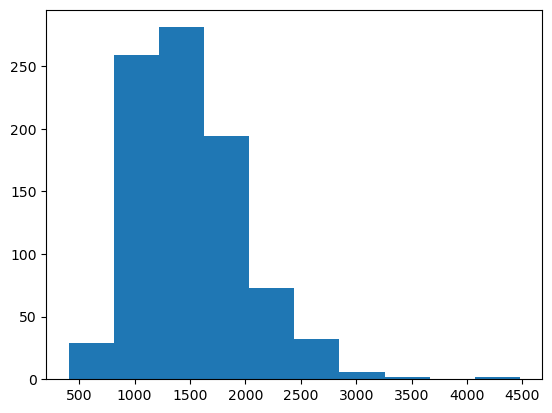

In [75]:
plt.hist(df['Gr Liv Area']);

In [76]:
df[df['Gr Liv Area']>4000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
170,1761,528320050,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,...,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD
463,1768,528351010,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,1,2007,WD


So there are indeed a couple such outlier observations.  However, since this is the *test* data set, we can't just remove these observations: we need to make predictions for them!  Even though we know in advance that our predictions will likely be off for these 2 observations (if the data description is correct), there's not much we can do about it.  Onward!